# 使用机器学习方法对elpv识别数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 复制images和labels数据
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/images ./images/
!cp -R /content/gdrive/MyDrive/UNSW/9517/LAB/group_project/labels.csv ./

## 探索数据预处理

<IPython.core.display.Javascript object>

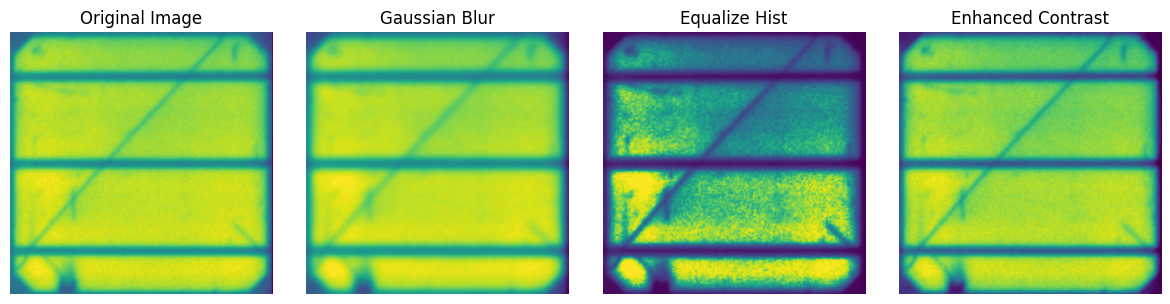

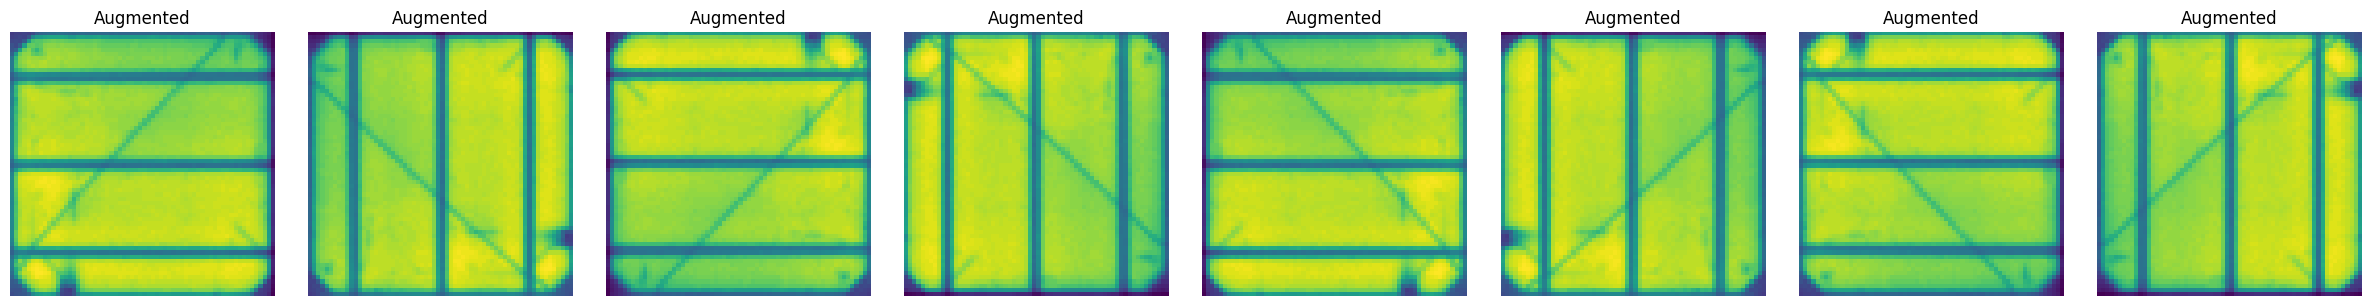

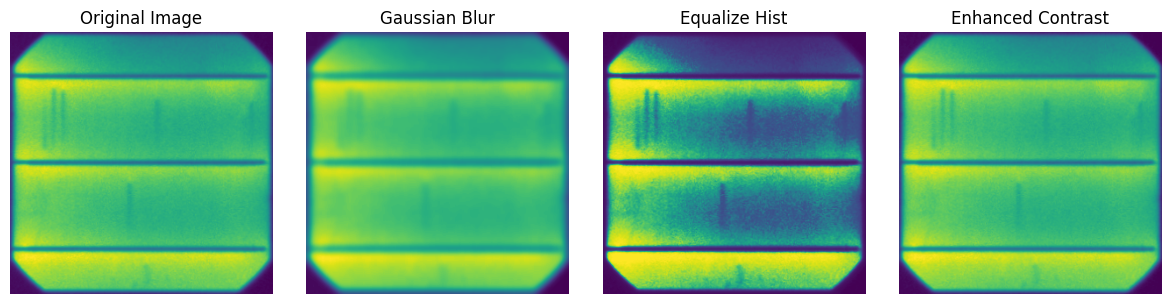

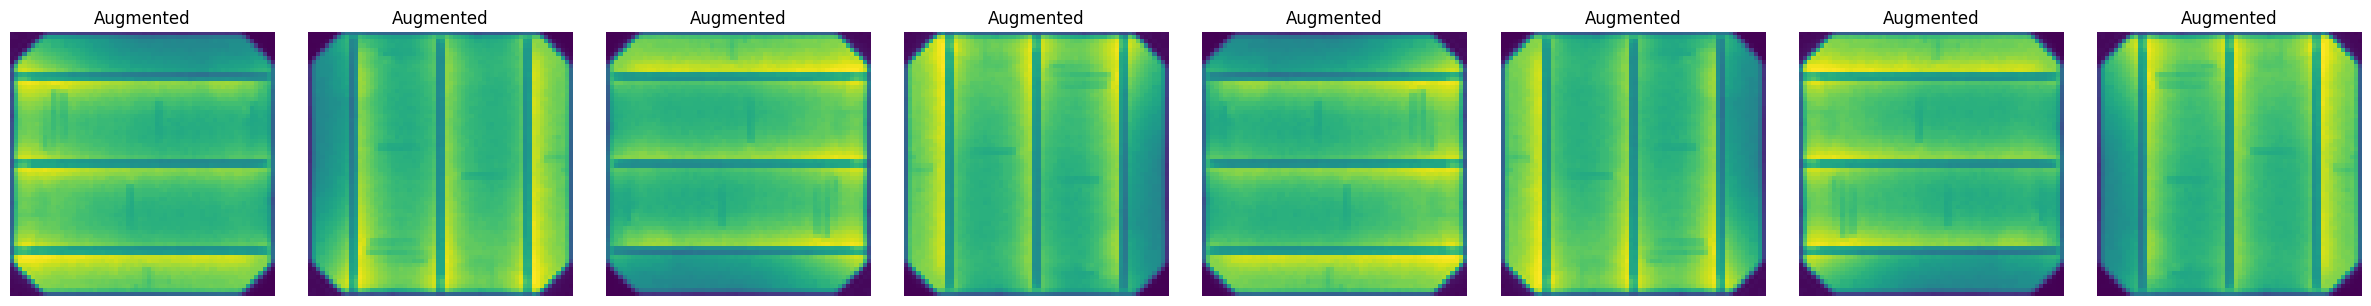

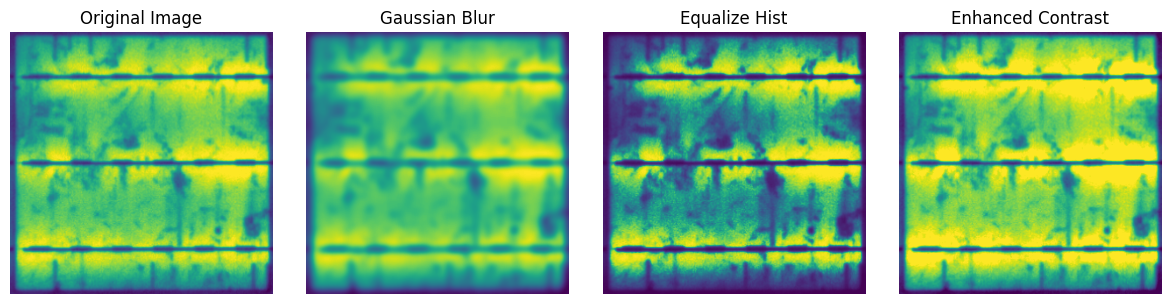

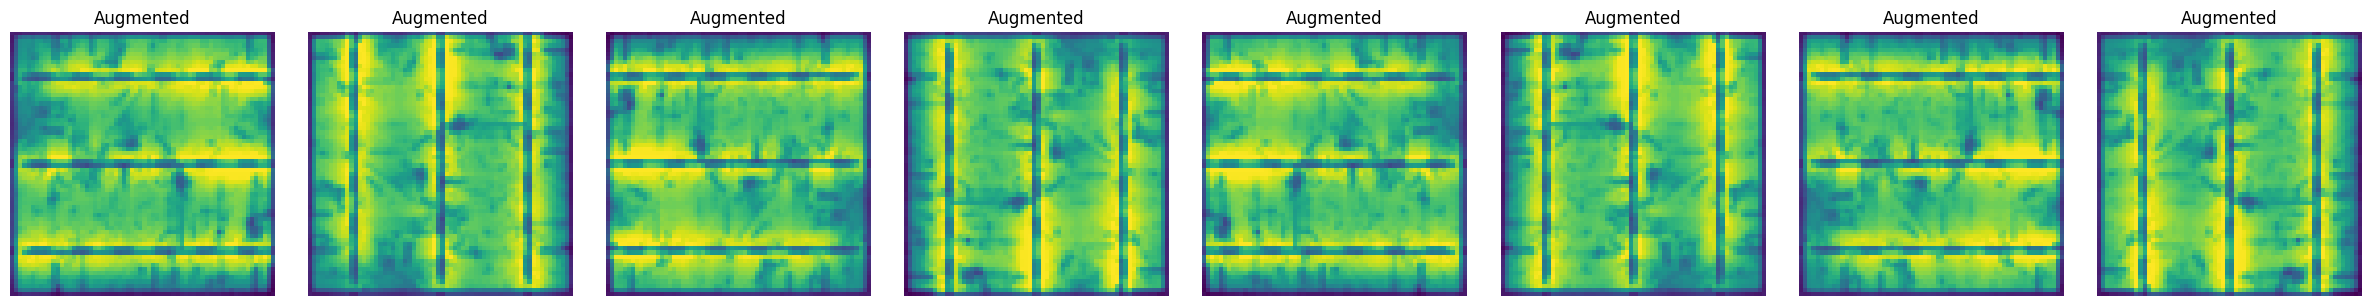

In [3]:
from IPython.display import Javascript

# 移除Colab输出区域的高度限制
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))

# 调用上面的函数以应用更改
remove_output_scrolling()



# 显示图片网格
def display_image_grid(images, titles, cols, filename):
    rows = (len(images) + cols - 1) // cols  # 计算所需的行数
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    if not isinstance(axes, np.ndarray):  # 如果axes不是数组（即只有一个subplot），将其转换为数组
        axes = np.array([axes])
    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{filename}.png")
    plt.show()

# 数据增强函数，产生旋转和翻转的图像
def augment_image(image, new_size):
    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)
    # 产生旋转和翻转的图像
    rotations = [0, 90, 180, 270]
    augmented_images = [image.rotate(angle) for angle in rotations]
    augmented_images += [ImageOps.mirror(img) for img in augmented_images]
    return augmented_images


# 主函数：加载数据、应用预处理、展示预处理和增强结果
def preprocess_and_display_images(fname, new_size=(64, 64), augment=False):
    # 读取图片路径
    data = np.genfromtxt(fname, dtype=[('path', 'U19')], delimiter=',', skip_header=1)
    image_fnames = data['path']

    # 处理前两张图片
    for i, fn in enumerate(image_fnames):
        if (i==1 or i==1000 or i==2000):
          img = Image.open(fn)
          processed_images = [img]  # 存储原图和预处理过的图像
          titles = ['Original Image']

          img_blurred = img.filter(ImageFilter.GaussianBlur(radius=3))
          processed_images.append(img_blurred)
          titles.append('Gaussian Blur')

          img_equalized = ImageOps.equalize(img)
          processed_images.append(img_equalized)
          titles.append('Equalize Hist')

          enhancer = ImageEnhance.Contrast(img)
          img_enhanced = enhancer.enhance(1.5)
          processed_images.append(img_enhanced)
          titles.append('Enhanced Contrast')

          # 展示预处理结果
          display_image_grid(processed_images, titles, 4, f"preprocessed_{i}")

          # 如果启用了数据增强，展示增强结果
          if augment:
              augmented_images = augment_image(img, new_size)
              augmented_titles = ['Augmented'] * len(augmented_images)
              display_image_grid(augmented_images, augmented_titles, 8, f"augmented_{i}")

# 调用函数
preprocess_and_display_images('labels.csv', augment=True)


## 数据加载，预处理和数据增强

###  定义数据预处理和数据增强函数

In [4]:
# 数据预处理
def preprocess_image(image, GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False):

    # 调整图像大小
    if image_resize:
      image = image.resize(new_size, Image.LANCZOS)

    # 图像去噪
    if GaussianBlur:
      image = image.filter(ImageFilter.GaussianBlur(radius=3))

    # 直方图均衡化
    if equalize_hist:
        image = ImageOps.equalize(image)

    # 对比度调整
    if enhance_contrast:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.5)  # 对比度增强因子，例如1.5

    return image


# 数据增强
def augment_image(image, new_size):
    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)
    # 数据增强：旋转和翻转
    rotations = [0, 90, 180, 270]
    flipped_image = ImageOps.mirror(image)  # 水平翻转
    rotated_images = [image.rotate(angle) for angle in rotations]
    rotated_flipped_images = [flipped_image.rotate(angle) for angle in rotations]
    return rotated_images + rotated_flipped_images



# 数据加载函数，包括预处理和数据增强
def load_dataset(fname='labels.csv',GaussianBlur=False, image_resize=False, new_size=(64, 64), enhance_contrast=False, equalize_hist=False, augment=False):
    data = np.genfromtxt(fname, dtype=[ \
      ('path', np.string_, 19), \
      ('probability', np.float64), \
      ('type', np.string_, 4)], \
      names=['path', 'probability', 'type'])

    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    dir = os.path.dirname(fname)
    images = []
    for fn in image_fnames:
        with Image.open(os.path.join(dir, fn)) as img:
            # 预处理图像
            processed_img = preprocess_image(img,GaussianBlur,image_resize,new_size,enhance_contrast,equalize_hist)
            images.append(np.asarray(processed_img))
            # 如果启用数据增强
            if augment:
                augmented_imgs = augment_image(processed_img, new_size)
                images.extend(np.asarray(img) for img in augmented_imgs)

    # 对所有图像进行归一化
    images = np.array(images).astype('float32') / 255.0

    # 如果进行了数据增强，则相应地重复概率和类型标签
    if augment:
        probs = np.repeat(probs, 9)  # 1原图 + 4旋转 + 4翻转后旋转
        types = np.repeat(types, 9)

    return images, probs, types


# 加载数据
images, probabilities, types = load_dataset(augment=False)

### 加载数据

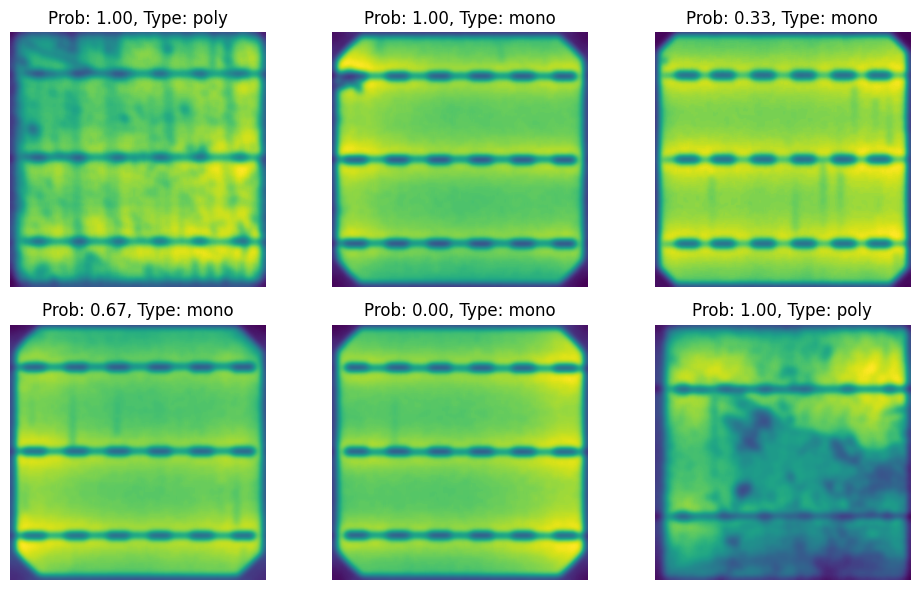

In [5]:
# 使用自带的加载函数来加载数据
images, probabilities, types = load_dataset(GaussianBlur=True, \
                        image_resize=False, new_size=(64, 64), \
                        enhance_contrast=False, \
                        equalize_hist=False,\
                        augment=False)


# 随机展示数据
def display_random_images_with_titles(images, probabilities=None, types=None, n_rows=2, n_cols=3):
    """
    Displays a grid of randomly selected images from a given ndarray of image arrays with titles.
    If probabilities or types are None, no titles will be displayed.

    Parameters:
    - images: An ndarray where each item is an image array.
    - probabilities: An optional ndarray of probabilities associated with each image.
    - types: An optional ndarray of types associated with each image.
    - n_rows: Number of rows in the subplot grid.
    - n_cols: Number of columns in the subplot grid.
    """
    # Number of images to display
    num_images = n_rows * n_cols

    # Ensure the array has the right number of dimensions
    assert images.ndim == 3, "Input images array must be 3-dimensional"

    # Ensure there are enough images to display
    assert images.shape[0] >= num_images, "Not enough images to display. Required: {}, Available: {}".format(num_images, images.shape[0])

    # Randomly select indices for images
    selected_indices = np.random.choice(images.shape[0], size=num_images, replace=False)

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))

    # Flatten the axes array for easy iteration if necessary
    axes_flat = axes.flat if n_rows * n_cols > 1 else [axes]

    # Check if probabilities and types are provided
    show_titles = probabilities is not None and types is not None

    # Iterate over the selected images and the subplot axes
    for ax, idx in zip(axes_flat, selected_indices):
        # Display the image
        ax.imshow(images[idx])
        if show_titles:
            # If probabilities and types are provided, display them as titles
            ax.set_title(f'Prob: {probabilities[idx]:.2f}, Type: {types[idx]}')
        ax.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

display_random_images_with_titles(images, probabilities, types, n_rows=2, n_cols=3)

### 拆分数据集

In [8]:
# 将图片数据展平成一维向量
images_flatten = np.array([img.flatten() for img in images])

# 标签编码
le_prob = LabelEncoder()
labels_prob = le_prob.fit_transform(probabilities)

# 分离出 'poly' 和 'mono' 的特征和标签
features_poly = images_flatten[types == 'poly']
labels_prob_poly = labels_prob[types == 'poly']

features_mono = images_flatten[types == 'mono']
labels_prob_mono = labels_prob[types == 'mono']

# 使用 train_test_split 分别拆分 'poly'数据，'mono' 数据
# 使用 stratify 进行分层抽样
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(features_poly, labels_prob_poly, test_size=0.25, random_state=15, stratify=labels_prob_poly)

X_train_mono, X_test_mono, y_train_mono, y_test_mono = train_test_split(features_mono, labels_prob_mono, test_size=0.25, random_state=15, stratify=labels_prob_mono)

### PCA降维

In [9]:
# PCA降维
pca_poly = PCA(n_components=0.95)
X_train_poly_pca = pca_poly.fit_transform(X_train_poly)
X_test_poly_pca = pca_poly.transform(X_test_poly)

pca_mono = PCA(n_components=0.95)
X_train_mono_pca = pca_mono.fit_transform(X_train_mono)
X_test_mono_pca = pca_mono.transform(X_test_mono)

print(pca_poly.n_components_)
print(pca_mono.n_components_)

51
14


## 6. 数据训练及预测

In [10]:
# 初始化变量以记录每次迭代的分数和最优分数
best_accuracy_poly_svm, total_accuracy_poly_svm = 0, 0
best_f1_score_poly_svm, total_f1_score_poly_svm = 0, 0
best_accuracy_poly_rf, total_accuracy_poly_rf = 0, 0
best_f1_score_poly_rf, total_f1_score_poly_rf = 0, 0
best_accuracy_mono_svm, total_accuracy_mono_svm = 0, 0
best_f1_score_mono_svm, total_f1_score_mono_svm = 0, 0
best_accuracy_mono_rf, total_accuracy_mono_rf = 0, 0
best_f1_score_mono_rf, total_f1_score_mono_rf = 0, 0

svm_predictions_poly = None
svm_predictions_mono = None
rf_predictions_poly = None
rf_predictions_mono = None

num_iterations = 30

for i in range(num_iterations):
    # 训练和预测-Poly数据
    svm_poly = SVC(kernel='rbf', gamma='scale')
    rf_poly = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    svm_poly.fit(X_train_poly_pca, y_train_poly)
    rf_poly.fit(X_train_poly_pca, y_train_poly)
    predictions_poly_svm = svm_poly.predict(X_test_poly_pca)
    predictions_poly_rf = rf_poly.predict(X_test_poly_pca)

    # 训练和预测-Mono数据
    svm_mono = SVC(kernel='rbf', gamma='scale')
    rf_mono = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    svm_mono.fit(X_train_mono_pca, y_train_mono)
    rf_mono.fit(X_train_mono_pca, y_train_mono)
    predictions_mono_svm = svm_mono.predict(X_test_mono_pca)
    predictions_mono_rf = rf_mono.predict(X_test_mono_pca)

    svm_predictions_poly = predictions_poly_svm
    svm_predictions_mono = predictions_mono_svm
    rf_predictions_poly = predictions_poly_rf
    rf_predictions_mono = predictions_mono_rf

    # 更新和记录分数-Poly数据
    current_accuracy_poly_svm = accuracy_score(y_test_poly, predictions_poly_svm)
    current_f1_score_poly_svm = f1_score(y_test_poly, predictions_poly_svm, average='weighted')
    total_accuracy_poly_svm += current_accuracy_poly_svm
    total_f1_score_poly_svm += current_f1_score_poly_svm
    if current_accuracy_poly_svm > best_accuracy_poly_svm:
        best_accuracy_poly_svm = current_accuracy_poly_svm
        best_f1_score_poly_svm = current_f1_score_poly_svm

    current_accuracy_poly_rf = accuracy_score(y_test_poly, predictions_poly_rf)
    current_f1_score_poly_rf = f1_score(y_test_poly, predictions_poly_rf, average='weighted')
    total_accuracy_poly_rf += current_accuracy_poly_rf
    total_f1_score_poly_rf += current_f1_score_poly_rf
    if current_accuracy_poly_rf > best_accuracy_poly_rf:
        best_accuracy_poly_rf = current_accuracy_poly_rf
        best_f1_score_poly_rf = current_f1_score_poly_rf


    # 更新和记录分数-Mono数据
    current_accuracy_mono_svm = accuracy_score(y_test_mono, predictions_mono_svm)
    current_f1_score_mono_svm = f1_score(y_test_mono, predictions_mono_svm, average='weighted')
    total_accuracy_mono_svm += current_accuracy_mono_svm
    total_f1_score_mono_svm += current_f1_score_mono_svm
    if current_accuracy_mono_svm > best_accuracy_mono_svm:
        best_accuracy_mono_svm = current_accuracy_mono_svm
        best_f1_score_mono_svm = current_f1_score_mono_svm

    current_accuracy_mono_rf = accuracy_score(y_test_mono, predictions_mono_rf)
    current_f1_score_mono_rf = f1_score(y_test_mono, predictions_mono_rf, average='weighted')
    total_accuracy_mono_rf += current_accuracy_mono_rf
    total_f1_score_mono_rf += current_f1_score_mono_rf
    if current_accuracy_mono_rf > best_accuracy_mono_rf:
        best_accuracy_mono_rf = current_accuracy_mono_rf
        best_f1_score_mono_rf = current_f1_score_mono_rf


In [13]:
n_test_poly = len(X_test_poly)
n_test_mono = len(X_test_mono)
print(n_test_poly,n_test_mono)

388 269


## 7. 展示预测结果

<IPython.core.display.Javascript object>

Average and Best Results:
Poly SVM - Avg Accuracy: 0.6701030927835052, Best Accuracy: 0.6701030927835051, Avg F1 Score: 0.6012082556062596, Best F1 Score: 0.6012082556062596
Mono SVM - Avg Accuracy: 0.7137546468401486, Best Accuracy: 0.7137546468401487, Avg F1 Score: 0.6499269499298027, Best F1 Score: 0.6499269499298022
Poly RF - Avg Accuracy: 0.7197594501718213, Best Accuracy: 0.7345360824742269, Avg F1 Score: 0.6816030415395049, Best F1 Score: 0.7003619243505551
Mono RF - Avg Accuracy: 0.7429987608426271, Best Accuracy: 0.7657992565055762, Avg F1 Score: 0.7172652891183272, Best F1 Score: 0.7431564864355593
SVM - Overall Accuracy: 0.6879756468797564, Overall F1 Score: 0.6211554835713023
RF - Overall Accuracy: 0.7292744799594114, Overall F1 Score: 0.6962044792848675


<Figure size 5000x3000 with 0 Axes>

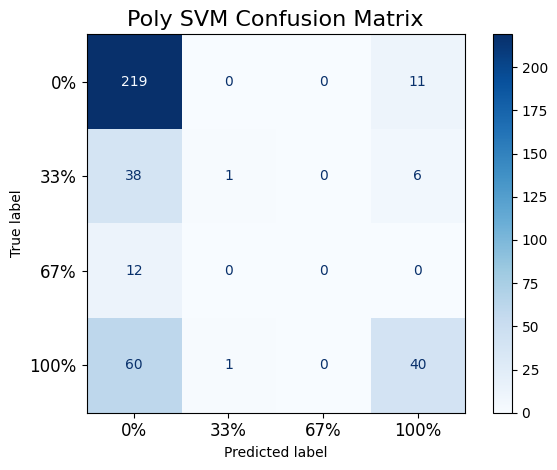

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.67      0.95      0.78       230
         33%       0.50      0.02      0.04        45
         67%       0.00      0.00      0.00        12
        100%       0.70      0.40      0.51       101

    accuracy                           0.67       388
   macro avg       0.47      0.34      0.33       388
weighted avg       0.64      0.67      0.60       388



<Figure size 5000x3000 with 0 Axes>

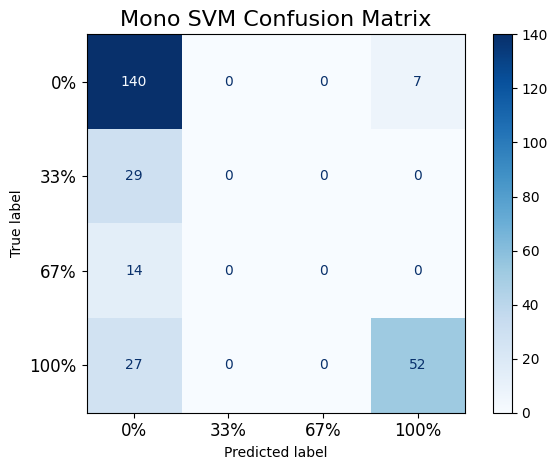

Mono SVM Classification Rep  ort:
               precision    recall  f1-score   support

          0%       0.67      0.95      0.78       147
         33%       0.00      0.00      0.00        29
         67%       0.00      0.00      0.00        14
        100%       0.88      0.66      0.75        79

    accuracy                           0.71       269
   macro avg       0.39      0.40      0.38       269
weighted avg       0.62      0.71      0.65       269



<Figure size 5000x3000 with 0 Axes>

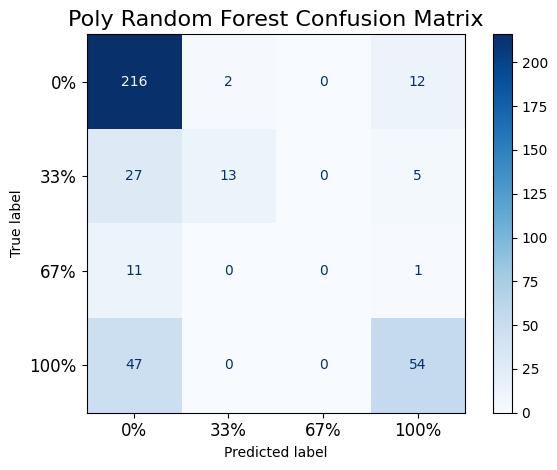

Poly Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.72      0.94      0.81       230
         33%       0.87      0.29      0.43        45
         67%       0.00      0.00      0.00        12
        100%       0.75      0.53      0.62       101

    accuracy                           0.73       388
   macro avg       0.58      0.44      0.47       388
weighted avg       0.72      0.73      0.70       388



<Figure size 5000x3000 with 0 Axes>

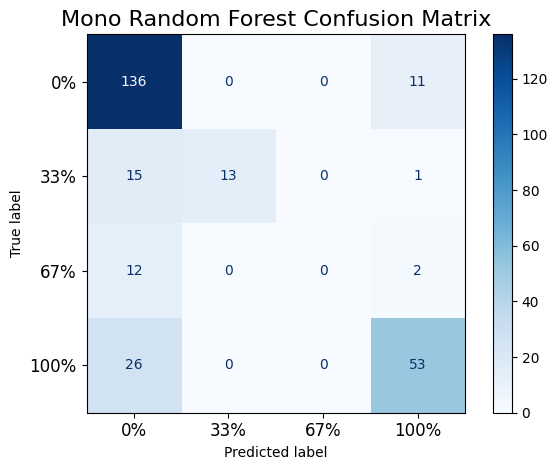

Mono Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.72      0.93      0.81       147
         33%       1.00      0.45      0.62        29
         67%       0.00      0.00      0.00        14
        100%       0.79      0.67      0.73        79

    accuracy                           0.75       269
   macro avg       0.63      0.51      0.54       269
weighted avg       0.73      0.75      0.72       269



In [11]:
from IPython.display import Javascript

# 移除Colab输出区域的高度限制
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))

# 调用上面的函数以应用更改
remove_output_scrolling()


# 计算30次的平均精度和F1分数
average_accuracy_poly_svm = total_accuracy_poly_svm / num_iterations
average_f1_score_poly_svm = total_f1_score_poly_svm / num_iterations
average_accuracy_poly_rf = total_accuracy_poly_rf / num_iterations
average_f1_score_poly_rf = total_f1_score_poly_rf / num_iterations
average_accuracy_mono_svm = total_accuracy_mono_svm / num_iterations
average_f1_score_mono_svm = total_f1_score_mono_svm / num_iterations
average_accuracy_mono_rf = total_accuracy_mono_rf / num_iterations
average_f1_score_mono_rf = total_f1_score_mono_rf / num_iterations

# 打印平均结果和最佳结果
print("Average and Best Results:")
print(f"Poly SVM - Avg Accuracy: {average_accuracy_poly_svm}, Best Accuracy: {best_accuracy_poly_svm}, Avg F1 Score: {average_f1_score_poly_svm}, Best F1 Score: {best_f1_score_poly_svm}")
print(f"Mono SVM - Avg Accuracy: {average_accuracy_mono_svm}, Best Accuracy: {best_accuracy_mono_svm}, Avg F1 Score: {average_f1_score_mono_svm}, Best F1 Score: {best_f1_score_mono_svm}")

print(f"Poly RF - Avg Accuracy: {average_accuracy_poly_rf}, Best Accuracy: {best_accuracy_poly_rf}, Avg F1 Score: {average_f1_score_poly_rf}, Best F1 Score: {best_f1_score_poly_rf}")
print(f"Mono RF - Avg Accuracy: {average_accuracy_mono_rf}, Best Accuracy: {best_accuracy_mono_rf}, Avg F1 Score: {average_f1_score_mono_rf}, Best F1 Score: {best_f1_score_mono_rf}")


# 计算整体(Poly+Mono)结果
n_test_poly = len(X_test_poly)
n_test_mono = len(X_test_mono)
# 总样本数量
total_samples = n_test_poly + n_test_mono
# 计算加权平均准确率和F1 score
weighted_acc_poly_svm = (average_accuracy_poly_svm * n_test_poly) / total_samples
weighted_acc_mono_svm = (average_accuracy_mono_svm * n_test_mono) / total_samples
total_accuracy_svm = weighted_acc_poly_svm + weighted_acc_mono_svm
weighted_acc_poly_rf = (average_accuracy_poly_rf * n_test_poly) / total_samples
weighted_acc_mono_rf = (average_accuracy_mono_rf * n_test_mono) / total_samples
total_accuracy_rf = weighted_acc_poly_rf + weighted_acc_mono_rf

weighted_f1_poly_svm = (average_f1_score_poly_svm * n_test_poly) / total_samples
weighted_f1_mono_svm = (average_f1_score_mono_svm * n_test_mono) / total_samples
total_f1_score_svm = weighted_f1_poly_svm + weighted_f1_mono_svm
weighted_f1_poly_rf = (average_f1_score_poly_rf * n_test_poly) / total_samples
weighted_f1_mono_rf = (average_f1_score_mono_rf * n_test_mono) / total_samples
total_f1_score_rf = weighted_f1_poly_rf + weighted_f1_mono_rf

print(f"SVM - Overall Accuracy: {total_accuracy_svm}, Overall F1 Score: {total_f1_score_svm}")
print(f"RF - Overall Accuracy: {total_accuracy_rf}, Overall F1 Score: {total_f1_score_rf}")

# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(50, 30), fontsize=12):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title, fontsize=fontsize+4)

    # 增加横纵坐标轴的字体大小
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    # 调整边距来确保内容的完整性
    plt.tight_layout()
    plt.show()

# 计算混淆矩阵
svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)

rf_cm_poly = confusion_matrix(y_test_poly, rf_predictions_poly)
rf_cm_mono = confusion_matrix(y_test_mono, rf_predictions_mono)

label_mapping = {
    0: '0%',
    1: '33%',
    2: '67%',
    3: '100%'
}

# 绘制混淆矩阵，打印分类报告
plot_confusion_matrix(svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly SVM Classification Report:\n", svm_report_poly)
plot_confusion_matrix(svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono SVM Classification Rep  ort:\n", svm_report_mono)


plot_confusion_matrix(rf_cm_poly, classes=list(label_mapping.values()), title='Poly Random Forest Confusion Matrix')
rf_report_poly = classification_report(y_test_poly, rf_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
print("Poly Random Forest Classification Report:\n", rf_report_poly)
plot_confusion_matrix(rf_cm_mono, classes=list(label_mapping.values()), title='Mono Random Forest Confusion Matrix')
rf_report_mono = classification_report(y_test_mono, rf_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)
print("Mono Random Forest Classification Report:\n", rf_report_mono)



## 使用随机森林+SVM的混合模型

<IPython.core.display.Javascript object>

Poly SVM - Avg Accuracy: 0.7415807560137456, Best Accuracy: 0.7654639175257731, Avg F1 Score: 0.7216009787145875, Best F1 Score: 0.7454285334181752
Mono SVM - Avg Accuracy: 0.7402726146220571, Best Accuracy: 0.7620817843866171, Avg F1 Score: 0.723360029215557, Best F1 Score: 0.7479024292625536


<Figure size 5000x3000 with 0 Axes>

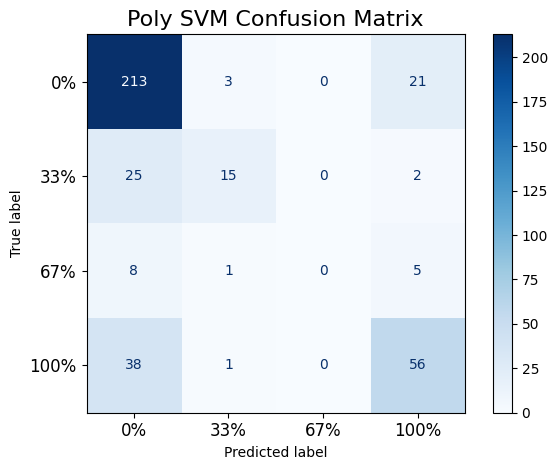

Poly SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.75      0.90      0.82       237
         33%       0.75      0.36      0.48        42
         67%       0.00      0.00      0.00        14
        100%       0.67      0.59      0.63        95

    accuracy                           0.73       388
   macro avg       0.54      0.46      0.48       388
weighted avg       0.70      0.73      0.71       388



<Figure size 5000x3000 with 0 Axes>

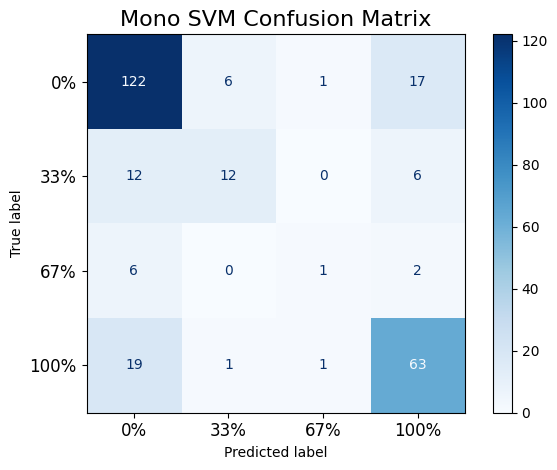

Mono SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.77      0.84      0.80       146
         33%       0.63      0.40      0.49        30
         67%       0.33      0.11      0.17         9
        100%       0.72      0.75      0.73        84

    accuracy                           0.74       269
   macro avg       0.61      0.52      0.55       269
weighted avg       0.72      0.74      0.72       269



In [ ]:
from IPython.display import Javascript

# 移除Colab输出区域的高度限制
def remove_output_scrolling():
    display(Javascript(
        'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
    ))

# 调用上面的函数以应用更改
remove_output_scrolling()


# 初始化变量以记录每次迭代的分数和最优分数
best_accuracy_poly_svm, total_accuracy_poly_svm = 0, 0
best_f1_score_poly_svm, total_f1_score_poly_svm = 0, 0
best_accuracy_mono_svm, total_accuracy_mono_svm = 0, 0
best_f1_score_mono_svm, total_f1_score_mono_svm = 0, 0


# 用于保存最后一次迭代的结果
last_svm_cm_poly, last_svm_cm_mono = None, None
last_svm_report_poly, last_svm_report_mono = None, None

for i in range(num_iterations):
    # 训练随机森林模型
    rf_poly = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf_poly.fit(X_train_poly_pca, y_train_poly)
    rf_mono = RandomForestClassifier(n_estimators=150, n_jobs=-1)
    rf_mono.fit(X_train_mono_pca, y_train_mono)

    # 使用随机森林模型生成新的特征集
    X_train_poly_rf = rf_poly.predict_proba(X_train_poly_pca)
    X_test_poly_rf = rf_poly.predict_proba(X_test_poly_pca)
    X_train_mono_rf = rf_mono.predict_proba(X_train_mono_pca)
    X_test_mono_rf = rf_mono.predict_proba(X_test_mono_pca)

    # 训练SVM模型
    svm_poly = SVC(kernel='rbf', gamma='scale', probability=True)
    svm_poly.fit(X_train_poly_rf, y_train_poly)
    svm_mono = SVC(kernel='rbf', gamma='scale', probability=True)
    svm_mono.fit(X_train_mono_rf, y_train_mono)

    # 进行预测
    svm_predictions_poly = svm_poly.predict(X_test_poly_rf)
    svm_predictions_mono = svm_mono.predict(X_test_mono_rf)

    # 计算精度和F1分数
    current_accuracy_poly_svm = accuracy_score(y_test_poly, svm_predictions_poly)
    current_f1_score_poly_svm = f1_score(y_test_poly, svm_predictions_poly, average='weighted')
    total_accuracy_poly_svm += current_accuracy_poly_svm
    total_f1_score_poly_svm += current_f1_score_poly_svm
    if current_accuracy_poly_svm > best_accuracy_poly_svm:
        best_accuracy_poly_svm = current_accuracy_poly_svm
        best_f1_score_poly_svm = current_f1_score_poly_svm

    current_accuracy_mono_svm = accuracy_score(y_test_mono, svm_predictions_mono)
    current_f1_score_mono_svm = f1_score(y_test_mono, svm_predictions_mono, average='weighted')
    total_accuracy_mono_svm += current_accuracy_mono_svm
    total_f1_score_mono_svm += current_f1_score_mono_svm
    if current_accuracy_mono_svm > best_accuracy_mono_svm:
        best_accuracy_mono_svm = current_accuracy_mono_svm
        best_f1_score_mono_svm = current_f1_score_mono_svm

    # 记录最后一次迭代的结果
    if i == num_iterations - 1:
        last_svm_cm_poly = confusion_matrix(y_test_poly, svm_predictions_poly)
        last_svm_report_poly = classification_report(y_test_poly, svm_predictions_poly, target_names=list(label_mapping.values()), zero_division=0)
        last_svm_cm_mono = confusion_matrix(y_test_mono, svm_predictions_mono)
        last_svm_report_mono = classification_report(y_test_mono, svm_predictions_mono, target_names=list(label_mapping.values()), zero_division=0)

# 计算平均精度和F1分数
average_accuracy_poly_svm = total_accuracy_poly_svm / num_iterations
average_f1_score_poly_svm = total_f1_score_poly_svm / num_iterations
average_accuracy_mono_svm = total_accuracy_mono_svm / num_iterations
average_f1_score_mono_svm = total_f1_score_mono_svm / num_iterations

# 打印平均和最佳结果
print(f"Poly SVM - Avg Accuracy: {average_accuracy_poly_svm}, Best Accuracy: {best_accuracy_poly_svm}, Avg F1 Score: {average_f1_score_poly_svm}, Best F1 Score: {best_f1_score_poly_svm}")
print(f"Mono SVM - Avg Accuracy: {average_accuracy_mono_svm}, Best Accuracy: {best_accuracy_mono_svm}, Avg F1 Score: {average_f1_score_mono_svm}, Best F1 Score: {best_f1_score_mono_svm}")

# 显示最后一次迭代的混淆矩阵和分类报告
plot_confusion_matrix(last_svm_cm_poly, classes=list(label_mapping.values()), title='Poly SVM Confusion Matrix')
print("Poly SVM Classification Report:\n", last_svm_report_poly)
plot_confusion_matrix(last_svm_cm_mono, classes=list(label_mapping.values()), title='Mono SVM Confusion Matrix')
print("Mono SVM Classification Report:\n", last_svm_report_mono)